#### Dirichlet-multinomial distribution

### http://users.cecs.anu.edu.au/~ssanner/MLSS2010/Johnson1.pdf


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pymc3 as pm

import pandas as pd

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\sidha\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def display_probs(d):
    for key, value in d.items():
        print(f'Species: {key:8} Prevalence: {100*value:.2f}%.')

In [40]:
def add_legend(ax):
    """Function to add legend to plots"""
    animals = ['lions', 'tigers', 'bears']
    for l, a in zip(ax.get_lines()[:3], animals):
        ax.plot(0, 0, label = a, c = l.get_color())
    ax.legend()

In [3]:
animals = ['lions', 'tigers', 'bears']
c = np.array([3, 2, 1])


In [4]:
# hyperparameters (initially all equal)
alphas = np.array([1, 1, 1])

In [5]:
display_probs(dict(zip(animals, (alphas + c) / (c.sum() + alphas.sum()))))

Species: lions    Prevalence: 44.44%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 22.22%.


### These values are expected. W ea renot taking the factor of uncertainity due to the limited data when we are computing this. 

In [6]:
# unequal hyper parameter values:
alpha_list = [np.array([0.1, 0.1, 0.1]), np.array([1, 1, 1]),
                    np.array([5, 5, 5]), np.array([15, 15, 15])]

In [7]:
values = []

for alpha_new in alpha_list:
    values.append((alpha_new + c) / (c.sum() + alpha_new.sum()))

value_df = pd.DataFrame(values, columns = animals)
value_df['alphas'] = [str(x) for x in alpha_list]
value_df

,lions,tigers,bears,alphas
0,0.492063,0.333333,0.174603,[0.1 0.1 0.1]
1,0.444444,0.333333,0.222222,[1 1 1]
2,0.380952,0.333333,0.285714,[5 5 5]
3,0.352941,0.333333,0.313725,[15 15 15]


In [8]:
melted = pd.melt(value_df, id_vars = 'alphas', value_name='prevalence',
        var_name = 'species')
melted

,alphas,species,prevalence
0,[0.1 0.1 0.1],lions,0.492063
1,[1 1 1],lions,0.444444
2,[5 5 5],lions,0.380952
3,[15 15 15],lions,0.352941
4,[0.1 0.1 0.1],tigers,0.333333
5,[1 1 1],tigers,0.333333
6,[5 5 5],tigers,0.333333
7,[15 15 15],tigers,0.333333
8,[0.1 0.1 0.1],bears,0.174603
9,[1 1 1],bears,0.222222


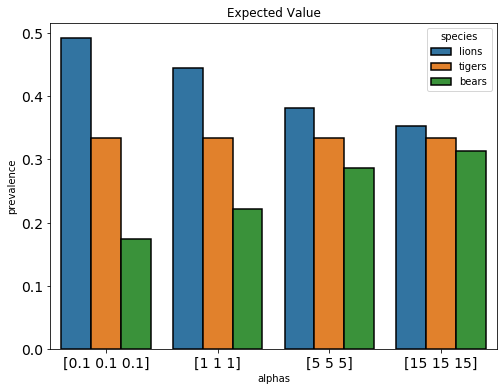

In [9]:
plt.figure(figsize = (8, 6))
sns.barplot(x = 'alphas', y = 'prevalence', hue = 'species', data = melted,
            edgecolor = 'k', linewidth = 1.5);
plt.xticks(size = 14); plt.yticks(size = 14)
plt.title('Expected Value');

### as the hyperparameter value increases, the expected prevelance converges to 0.333.  with heavier priors, the observations matter less 

### on the other hand if the weights of hyperparameter is less then the observed data matters more and the expected value converges to counts. 
### the value of hyperparameter depends on our confidence in prior belied

$${\displaystyle \operatorname {arg\,max} \limits _{\mathbf {p} }p(\mathbf {p} \mid \mathbb {X} )={\frac {\alpha _{i}+c_{i}-1}{\sum _{i}(\alpha _{i}+c_{i}-1)}},\qquad \forall i\;\alpha _{i}+c_{i}>1}$$

In [10]:
display_probs(dict(zip(animals, (alphas + c - 1) / sum(alphas + c - 1))))


Species: lions    Prevalence: 50.00%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 16.67%.


In [11]:
values = []
for alpha_new in alpha_list:
    values.append((alpha_new + c - 1) / sum(alpha_new + c - 1))

value_df = pd.DataFrame(values, columns = animals)
value_df['alphas'] = [str(x) for x in alpha_list]
value_df

,lions,tigers,bears,alphas
0,0.636364,0.333333,0.030303,[0.1 0.1 0.1]
1,0.500000,0.333333,0.166667,[1 1 1]
2,0.388889,0.333333,0.277778,[5 5 5]
3,0.354167,0.333333,0.312500,[15 15 15]


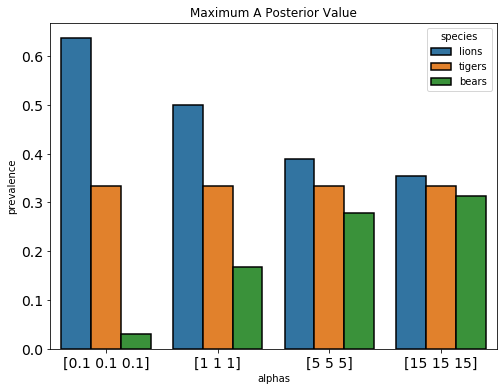

In [12]:
melted = pd.melt(value_df, id_vars = 'alphas', value_name='prevalence',
        var_name = 'species')

plt.figure(figsize = (8, 6))
sns.barplot(x = 'alphas', y = 'prevalence', hue = 'species', data = melted,
            edgecolor = 'k', linewidth = 1.5);
plt.xticks(size = 14); plt.yticks(size = 14)
plt.title('Maximum A Posterior Value');

## Bayesian Model(PyMC3 and MCMC)

In [18]:
 with pm.Model() as model:
        # parameters for multinomial are from dir
        parameters = pm.Dirichlet('parameters', a= alphas, shape=3)
        # observed data is from multinomial distribution
        observed_data = pm.Multinomial('observed_data',n=6,p=parameters,shape=3,observed=c)

#### samples 1000 draws from the posterior in 2 chains. 500 samples for tuning which are discarded. the posterior distribution.

In [21]:
with model:
    # Sample from the posterior
    trace = pm.sample(draws=1000, tune=500, discard_tuned_samples=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [parameters]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 65 seconds.
There were 218 divergences after tuning. Increase `target_accept` or reparameterize.
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
There were 171 divergences after tuning. Increase `target_accept` or reparameterize.


In [22]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lions,0.443,0.159,0.156,0.746,0.003,0.002,2299.0,2224.0,2292.0,1924.0,1.0
tigers,0.332,0.153,0.063,0.610,0.003,0.002,2618.0,2518.0,2589.0,2380.0,1.0
bears,0.225,0.134,0.010,0.469,0.003,0.002,2662.0,2422.0,2586.0,2173.0,1.0


In [24]:
trace['parameters']

array([[0.36471523, 0.61012104, 0.02516373],
       [0.49777808, 0.27629651, 0.22592541],
       [0.56580222, 0.33299035, 0.10120743],
       ...,
       [0.38825432, 0.31692581, 0.29481987],
       [0.61096663, 0.14180162, 0.24723175],
       [0.5942349 , 0.0980045 , 0.3077606 ]])

In [28]:
# Samples
trace_df = pd.DataFrame(trace['parameters'], columns = animals)
trace_df.head()

,lions,tigers,bears
0,0.364715,0.610121,0.025164
1,0.497778,0.276297,0.225925
2,0.565802,0.332990,0.101207
3,0.531520,0.336281,0.132199
4,0.531520,0.336281,0.132199


In [30]:
trace_df.shape

(4000, 3)

In [32]:
trace_df.iloc[:, :3].mean()

lions     0.443443
tigers    0.332039
bears     0.224518
dtype: float64

## Posterior plots

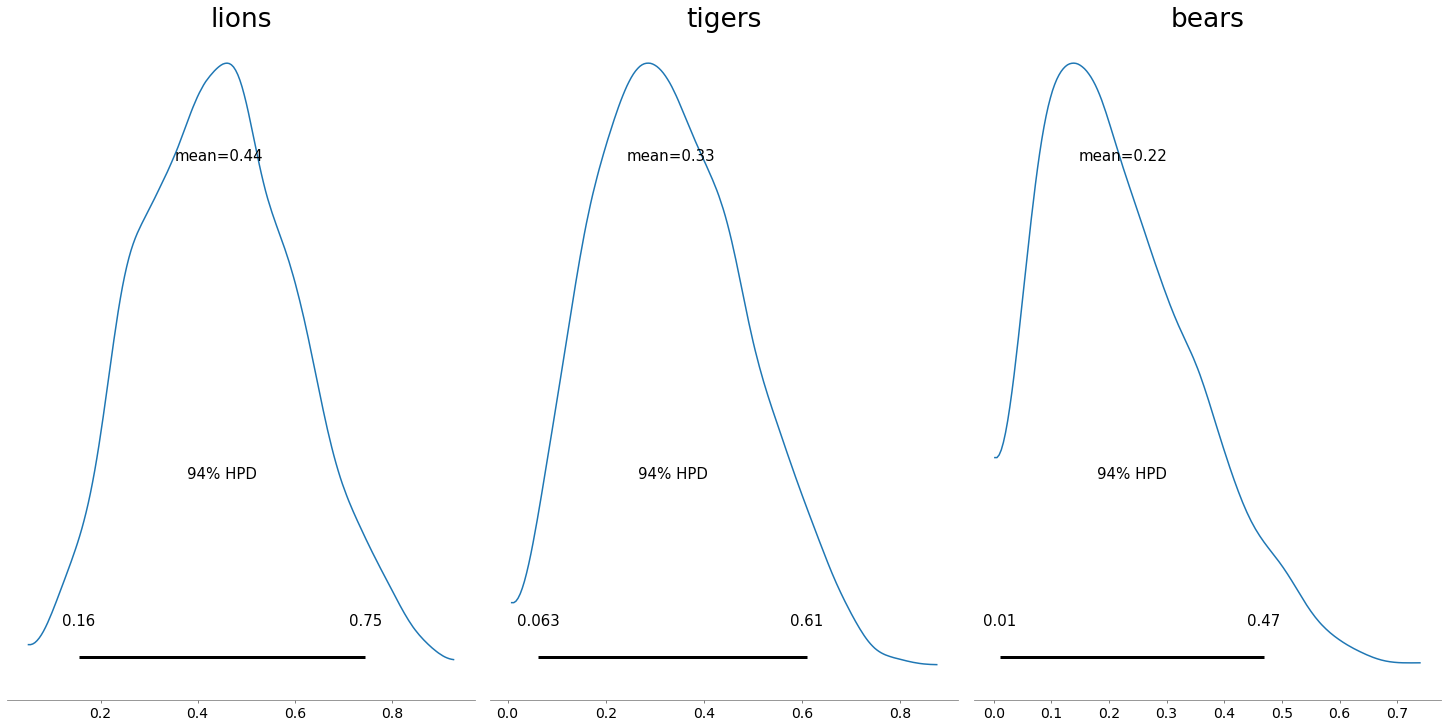

In [36]:
ax = pm.plots.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10))

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);

## Trace plots

C:\Users\sidha\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


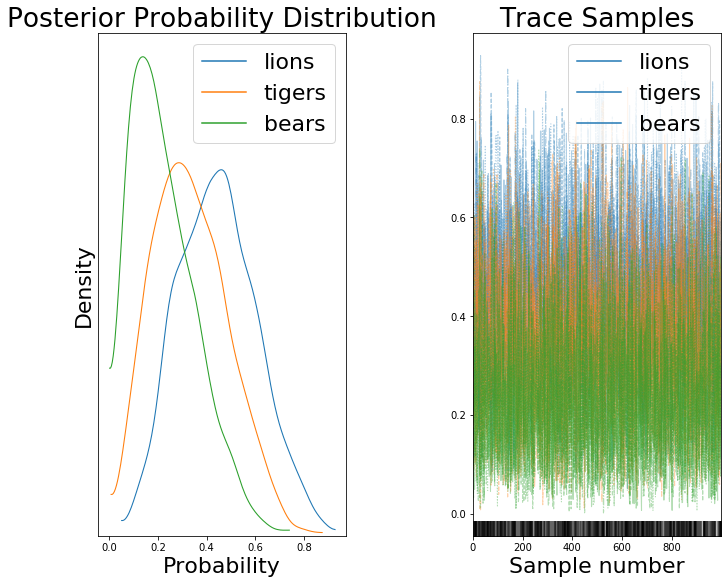

In [41]:
ax = pm.traceplot(trace, varnames = ['parameters'], figsize = (10, 8), combined = True);
ax[0][0].set_title('Posterior Probability Distribution'); ax[0][1].set_title('Trace Samples');
ax[0][0].set_xlabel('Probability'); ax[0][0].set_ylabel('Density');
ax[0][1].set_xlabel('Sample number');
add_legend(ax[0][0])
add_legend(ax[0][1])

In [44]:
trace.varnames

['parameters_stickbreaking__', 'parameters']

# Concept
## Hyperparameters and our belief/prior
### Dirichlet parameter vector can be considered as pseudocounts, which represents the observation of each outcome that occur before knowing actual data. This capture how much we believe in our data. if we saw that alpha = [1,1,1] means that the prevalence of each animal is the same before going to the forest. If we expect more lions then the new value will be [1,1,2]. Greater the values, greater effect of prior will be on posterior. Smaller the values -> samller the effect on posterior and hence actual data will dominate the posterior. Greater value reflects the strong confidence on our prior. 

## Next step

### 1. we will add more ovservations in the data and willsee how it goes
### 2. we are going to implement the different values of Hyperparameters (Alpha), to see Increasing and Decreasing Confidence in Prior Beliefs. If we are incresing the value of Alpha then we are increasing the beliefs on prior. We know that the hyperparameters can be thought of as pseudocounts that represent our prior belief. If the values of alpha are equal to one then the the beliefs are ...........



In [45]:
c = np.array([[3, 2, 1],
              [2, 3, 1],
              [3, 2, 1],
              [2, 3, 1],
              [0, 3, 3]])

with pm.Model() as model:
    # Parameters are a dirichlet distribution
    parameters = pm.Dirichlet('parameters', a=alphas, shape=3)
    # Observed data is a multinomial distribution
    observed_data = pm.Multinomial(
        'observed_data', n=6, p=parameters, shape=3, observed=c)    
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 72 seconds.
There were 214 divergences after tuning. Increase `target_accept` or reparameterize.
There were 193 divergences after tuning. Increase `target_accept` or reparameterize.


In [46]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lions,0.331,0.080,0.178,0.474,0.002,0.001,1668.0,1667.0,1627.0,1133.0,1.00
tigers,0.422,0.087,0.265,0.583,0.003,0.002,1216.0,1216.0,1186.0,1052.0,1.01
bears,0.247,0.074,0.116,0.384,0.002,0.001,1536.0,1425.0,1569.0,1318.0,1.00


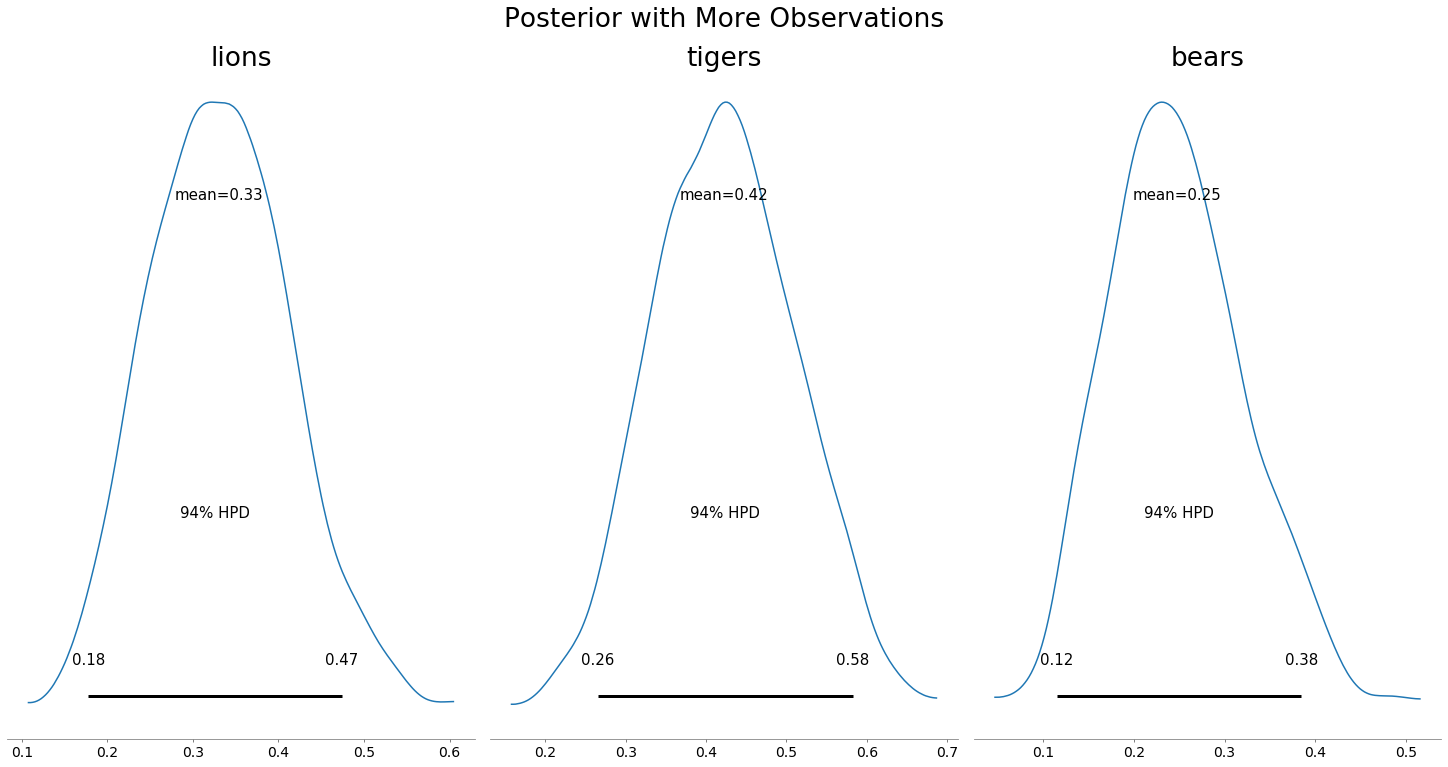

In [50]:
ax = pm.plot_posterior(trace, varnames = ['parameters'], figsize = (20, 10));
plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);
    
plt.suptitle('Posterior with More Observations', y = 1.05);

In [53]:
# making the funcition and passing the alpha as argument and returning the reace values
# observations
animals = ['lions', 'tigers', 'bears']
c = np.array([3, 2, 1])

def sample_with_priors(alphas):
    """Sample with specified hyperparameters"""
    with pm.Model() as model:
        # Probabilities for each species
        parameters = pm.Dirichlet('parameters', a=alphas, shape=3)
        # Observed data is a multinomial distribution with 6 trials
        observed_data = pm.Multinomial(
            'observed_data', n=6, p=parameters, shape=3, observed=c)    

        trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)
    return trace

trace_dict = {}
for alpha_array in alpha_list:
    trace_dict[str(alpha_array[0])] = sample_with_priors(alpha_array)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 78 seconds.
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
There were 223 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 69 seconds.
There were 141 divergences after tuning. Increase `target_accept` or reparameterize.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 75 seconds.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 92 seconds.
There were 217 divergences after tuning. Increase `target_accept` or reparameterize.
There were 236 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9102802857599461, but should be close to 0.8. Try to increase the number of tuning steps.


In [54]:
print(trace_dict.items())
print(trace_dict.keys())

dict_items([('0.1', <MultiTrace: 2 chains, 1000 iterations, 2 variables>), ('1', <MultiTrace: 2 chains, 1000 iterations, 2 variables>), ('5', <MultiTrace: 2 chains, 1000 iterations, 2 variables>), ('15', <MultiTrace: 2 chains, 1000 iterations, 2 variables>)])
dict_keys(['0.1', '1', '5', '15'])


In [ ]:
ax = pm.plot_posterior(trace, varnames = ['parameters'], figsize = (20, 10));
plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);
    
plt.suptitle('Posterior with More Observations', y = 1.05);

In [ ]:
ax = pm.traceplot(trace, varnames = ['parameters'], figsize = (10, 8), combined = True);

C:\Users\sidha\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
C:\Users\sidha\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
C:\Users\sidha\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
C:\Users\sidha\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var

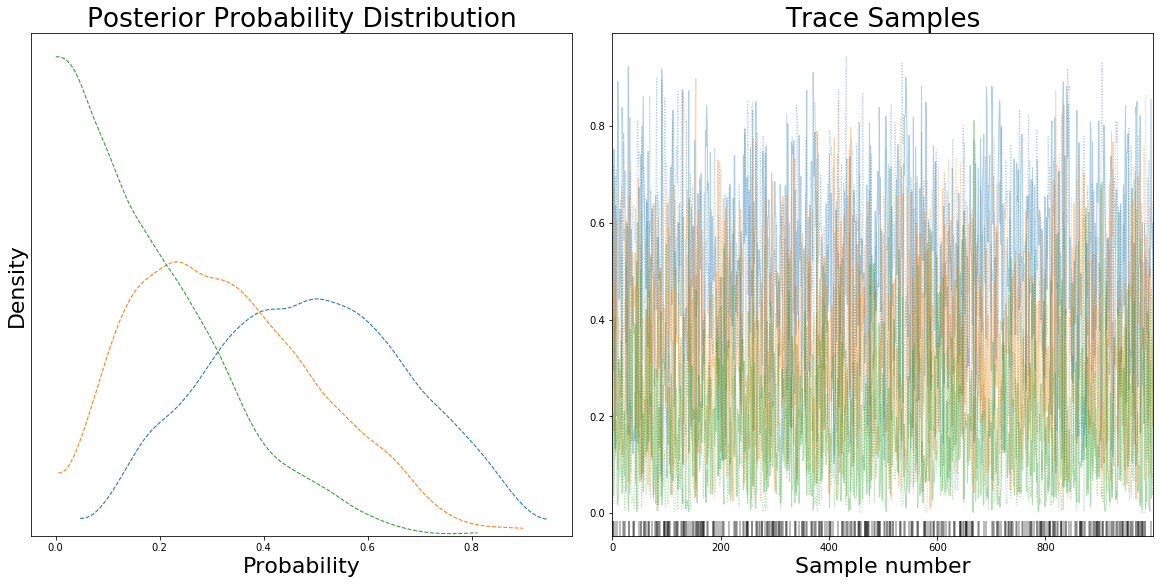

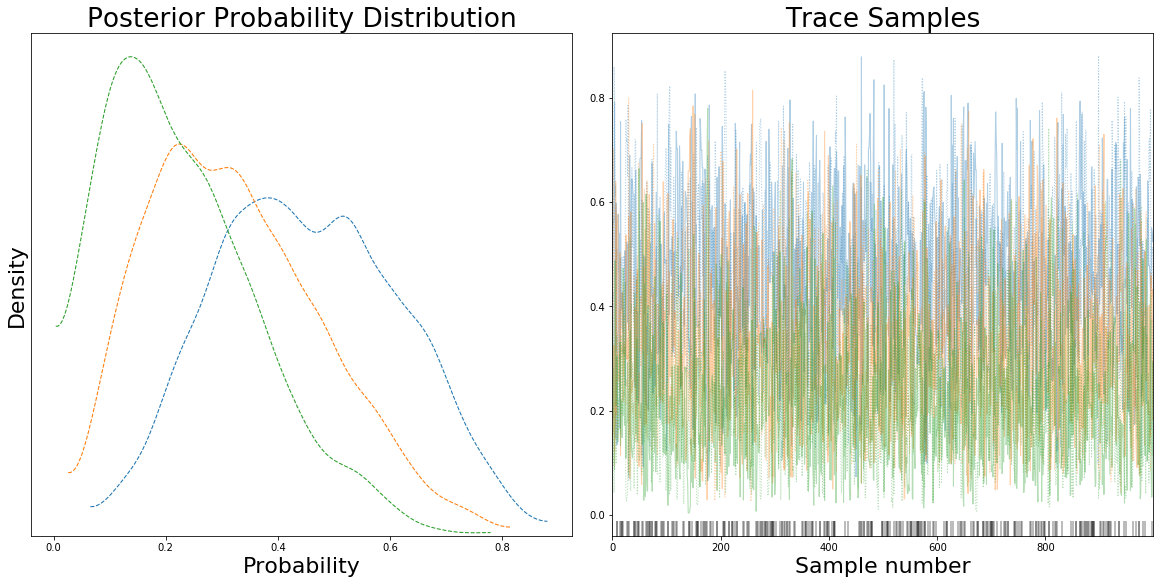

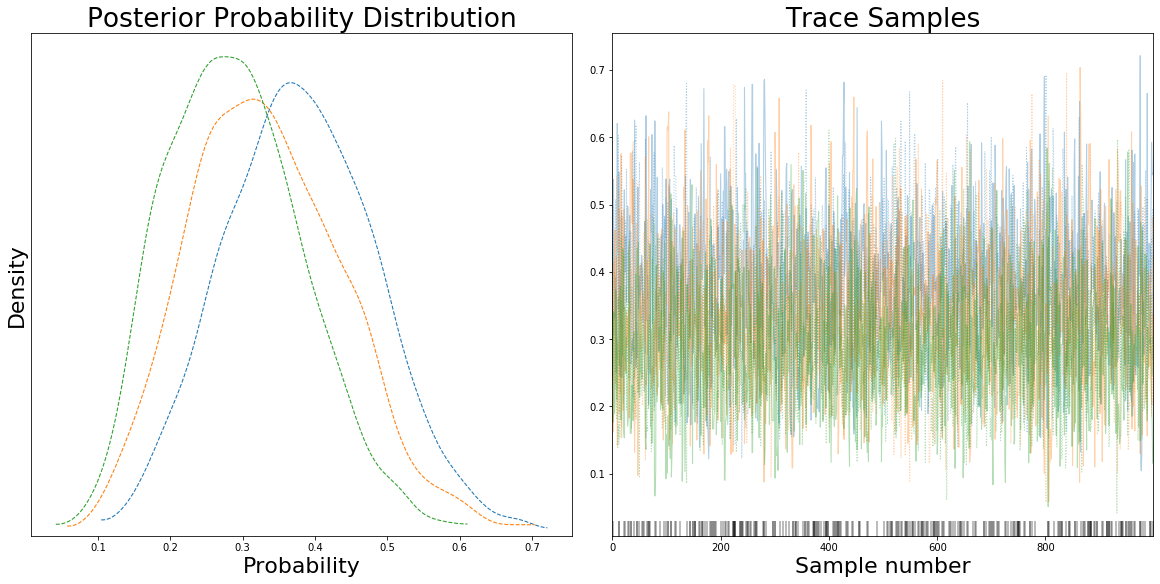

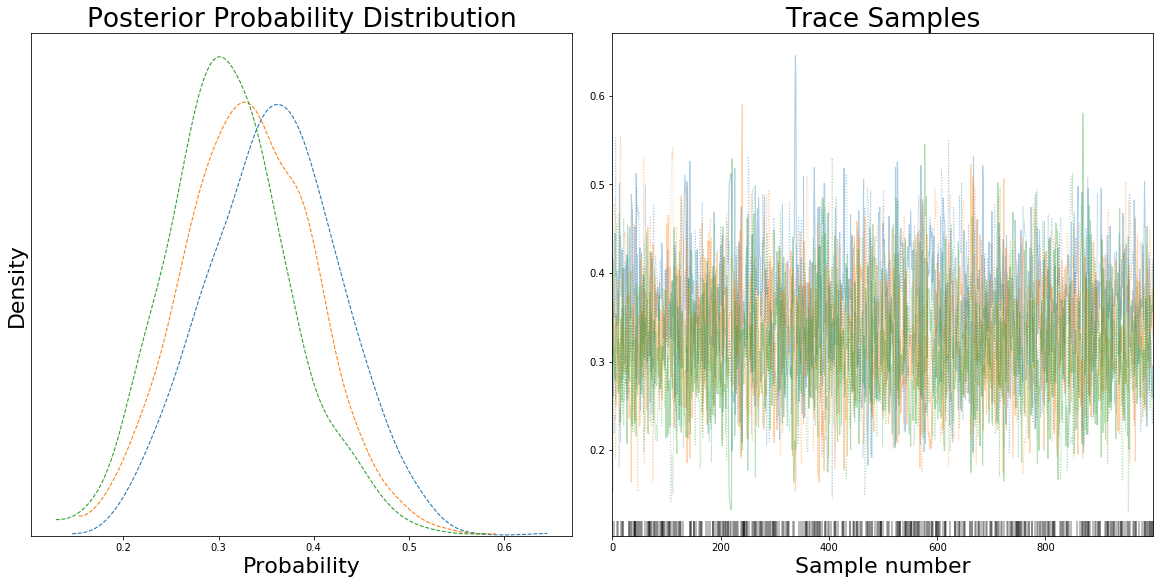

In [62]:
for ii, (alpha, trace) in enumerate(trace_dict.items()):
    ax = pm.traceplot(trace, varnames = ['parameters'], figsize = (16, 8), combined = True)
    ax[0][0].set_title('Posterior Probability Distribution')
    ax[0][1].set_title('Trace Samples')
    ax[0][0].set_xlabel('Probability')
    ax[0][0].set_ylabel('Density')
    ax[0][1].set_xlabel('Sample number')

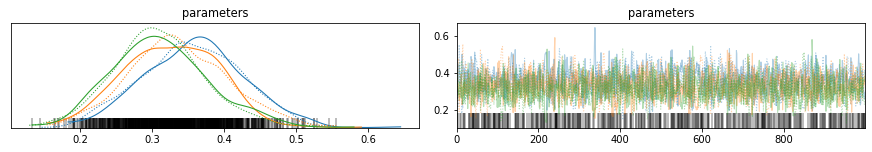

In [63]:
pm.traceplot(trace)

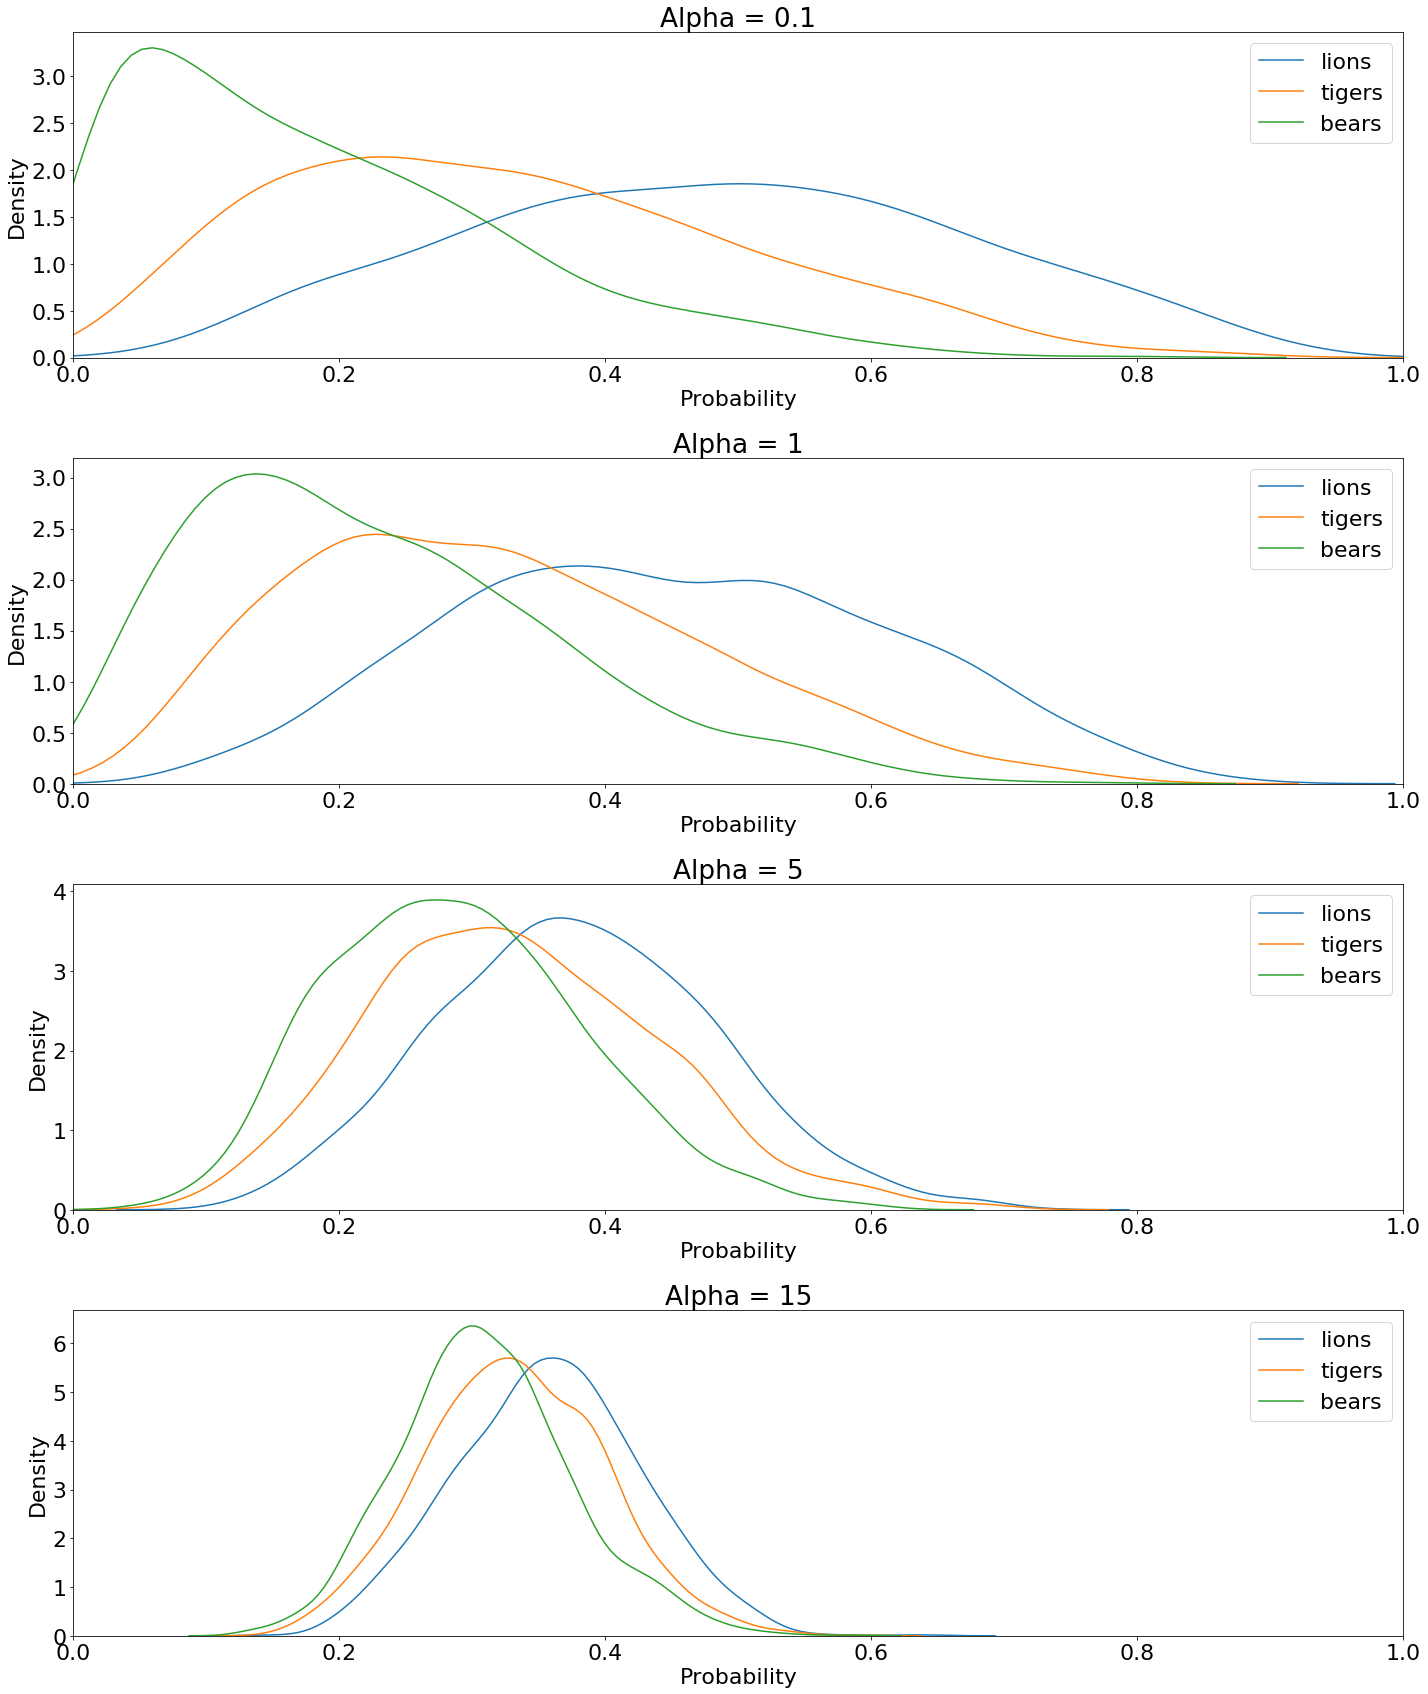

In [59]:
plt.figure(figsize = (20, 24))

for ii, (alpha, trace) in enumerate(trace_dict.items()):
    plt.subplot(4, 1, ii + 1)
    array = trace['parameters']
    for jj, animal in enumerate(animals):
        sns.kdeplot(array[:, jj], label = f'{animal}')
        #sns.kdeplot(array[:, jj])
    plt.legend();
    plt.xlabel('Probability'); plt.ylabel('Density')
    plt.title(f'Alpha = {alpha}');
    plt.xlim((0, 1));
    
plt.tight_layout();
plt.show();

In [64]:
size = 50
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
y = true_intercept + x*true_slope + np.random.normal(scale=.5, size=size)

(array([1., 0., 2., 1., 1., 5., 7., 4., 6., 6., 4., 6., 4., 2., 1.]),
 array([0.11922109, 0.33680982, 0.55439855, 0.77198727, 0.989576  ,
        1.20716473, 1.42475346, 1.64234219, 1.85993092, 2.07751964,
        2.29510837, 2.5126971 , 2.73028583, 2.94787456, 3.16546328,
        3.38305201]),
 <a list of 15 Patch objects>)

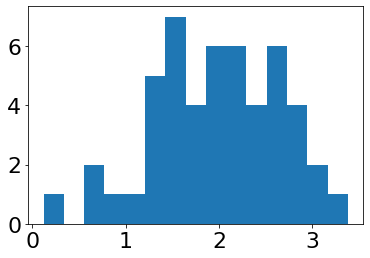

In [70]:
plt.hist(y, bins = 15)